In [1]:
%load_ext lab_black
%load_ext autotime
import pandas as pd
import numpy as np

time: 245 ms (started: 2022-09-15 22:51:27 -07:00)


A set of images of a face under different rotations and lighting conditions, used as a dataset in Isomap. Unfortunately, it’s no longer available at the Stanford website, but we can rescue it from the mists of time via the [Wayback Machine](https://web.archive.org/web/20150922051706/http://isomap.stanford.edu/face_data.mat.Z).

To make things even more complicated, this file has been Z-compressed, which means you would need to uncompress this with e.g. `uncompress` (on Linux) or 7-zip (on Windows). There are some python packages that can do this for you on PyPI including [unlzw](https://pypi.org/project/unlzw/) and [unlzw3](https://pypi.org/project/unlzw3/) and [ncompress](https://pypi.org/project/ncompress/) (thank you to this [stack overflow page](https://stackoverflow.com/q/32921263/4096483)). I chose `ncompress` pretty much arbitrarily. I leaned heavily on [a gist](https://gist.github.com/jlmelville/339dfeb80c3e836e887d70a37679b244) for R to remember how to do this.

In [2]:
from io import BytesIO

import ncompress
import requests
import scipy.io

req = requests.get(
    "https://web.archive.org/web/20150922051706/http://isomap.stanford.edu:80/face_data.mat.Z",
    timeout=10,
)
faces_data = scipy.io.loadmat(
    BytesIO(ncompress.decompress(req.content)), squeeze_me=True, struct_as_record=False
)

# Equivalent with ulzw3 if ncompress doesn't work out for you:
# import unlzw3
# faces_data = scipy.io.loadmat(
#     BytesIO(unlzw3.unlzw(req.content)), squeeze_me=True, struct_as_record=False
# )

time: 1.51 s (started: 2022-09-15 22:51:27 -07:00)


In [3]:
faces_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'lights', 'images', 'image_pcs', 'poses'])

time: 7.52 ms (started: 2022-09-15 22:51:29 -07:00)


In [4]:
faces_data["images"].shape

(4096, 698)

time: 3.14 ms (started: 2022-09-15 22:51:29 -07:00)


There are 698 images, each being 64 x 64 pixels in size. The data is stored by column, not row.

## View a face

In [5]:
import matplotlib.pyplot as plt


def show_face(faces, idx):
    nx = 64
    ny = nx
    plt.axis("off")
    plt.imshow(
        faces[:, idx].reshape((nx, ny)).T,
        cmap=plt.cm.gray,
        interpolation="nearest",
        vmin=0,
        vmax=1,
    )

time: 474 ms (started: 2022-09-15 22:51:29 -07:00)


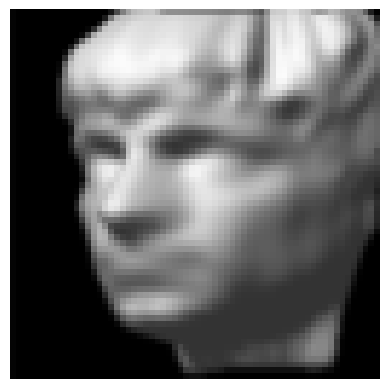

time: 67.5 ms (started: 2022-09-15 22:51:29 -07:00)


In [6]:
show_face(faces_data["images"], 0)

## Data pipeline

Data needs to be transposed to have each image in the rows:

In [7]:
data = faces_data["images"].T

time: 913 µs (started: 2022-09-15 22:51:29 -07:00)


The `poses` data relates to the angle of the head in each image. Either could be used to color the manifold.

In [8]:
faces_data["poses"].shape

(2, 698)

time: 3.71 ms (started: 2022-09-15 22:51:29 -07:00)


In [9]:
target = pd.DataFrame(dict(pose1=faces_data["poses"][0], pose2=faces_data["poses"][1]))

time: 3.01 ms (started: 2022-09-15 22:51:29 -07:00)


In [10]:
target

,pose1,pose2
0,-32.119184,-0.791317
1,29.043989,-1.963342
2,-28.112839,0.834203
3,59.262967,-9.700989
4,-42.009602,9.401733
...,...,...
693,-34.086428,5.489509
694,-48.328393,9.410430
695,69.475295,1.254550
696,24.340441,-5.578956


time: 10.3 ms (started: 2022-09-15 22:51:29 -07:00)


In [11]:
faces_data["image_pcs"].shape

(240, 698)

time: 3.63 ms (started: 2022-09-15 22:51:29 -07:00)


In [13]:
from drnb.io.pipeline import create_default_pipeline

data_result = create_default_pipeline(check_for_duplicates=True).run(
    "isofaces",
    data=data,
    target=target,
    tags=["small", "synthetic", "image", "isomap"],
    verbose=True,
)

[23:01:07] INFO     Requesting one extra neighbor to account for self-neighbor                      ]8;id=955709;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=225536;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#392\392]8;;\

           INFO     Initial data shape: (698, 4096)                                                  ]8;id=524785;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=83499;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#80\80]8;;\

           INFO     Keeping all columns                                                            ]8;id=555971;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=90892;file:///home/james/dev/drnb/src/drnb/preprocess.py#62\62]8;;\

           INFO     Data shape after filtering columns: (698, 4096)                                 ]8;id=720831;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=492122;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#151\151]8;;\

           INFO     Removing rows with NAs                                                          ]8;id=385122;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=94572;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#135\135]8;;\

           INFO     Data shape after filtering NAs: (698, 4096)                                     ]8;id=783678;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=276028;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#146\146]8;;\

           INFO     Checked for duplicates: found 0                                                 ]8;id=79447;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=818971;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#158\158]8;;\

           INFO     No scaling                                                                     ]8;id=310892;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=787360;file:///home/james/dev/drnb/src/drnb/preprocess.py#25\25]8;;\

           INFO     Converting to numpy with {'dtype': 'float32', 'layout': 'c'}                    ]8;id=642168;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=585784;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#163\163]8;;\

           INFO     Writing data for isofaces                                                       ]8;id=972344;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=50002;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#225\225]8;;\

[23:01:08] INFO     Processing target with initial shape (698, 2)                                   ]8;id=363917;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=748920;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#196\196]8;;\

           INFO     Keeping all columns                                                            ]8;id=765233;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=328326;file:///home/james/dev/drnb/src/drnb/preprocess.py#62\62]8;;\

           INFO     Writing target for isofaces                                                     ]8;id=859300;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=55208;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#225\225]8;;\

           INFO     Calculating nearest neighbors                                                   ]8;id=945186;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=421106;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#240\240]8;;\

           INFO     Finding 151 neighbors using faiss with euclidean metric and params: {}           ]8;id=163532;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=189533;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py#71\71]8;;\

[23:01:09] INFO     Calculating triplets                                                            ]8;id=421088;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=2065;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#276\276]8;;\

           INFO     Writing csv format to triplets/isofaces.5.1337.idx.csv                          ]8;id=942377;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=252456;file:///home/james/dev/drnb/src/drnb/io/__init__.py#221\221]8;;\

           INFO     Writing csv format to triplets/isofaces.5.1337.l2.csv                           ]8;id=458571;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=76115;file:///home/james/dev/drnb/src/drnb/io/__init__.py#221\221]8;;\

           INFO     Writing numpy format to triplets/isofaces.5.1337.idx.npy                        ]8;id=728840;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=708209;file:///home/james/dev/drnb/src/drnb/io/__init__.py#244\244]8;;\

           INFO     Writing numpy format to triplets/isofaces.5.1337.l2.npy                         ]8;id=288623;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=280410;file:///home/james/dev/drnb/src/drnb/io/__init__.py#244\244]8;;\

           INFO     Writing pipeline result for isofaces                                            ]8;id=482390;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=762553;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#128\128]8;;\

time: 2.78 s (started: 2022-09-15 23:01:07 -07:00)
